## Deep patterns

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image

### Helper functions

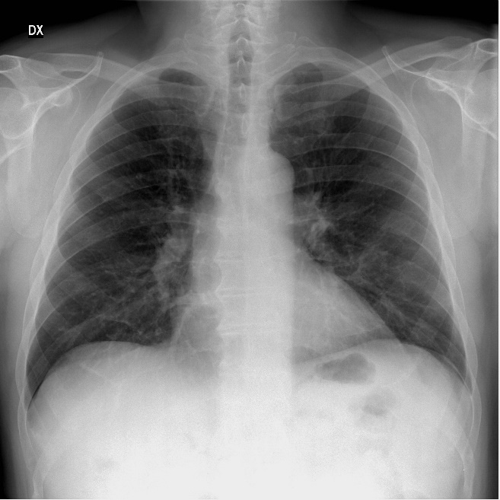

In [10]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  image_path = url
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
url='/content/covid.jpeg'
original_img = download(url, max_dim=500)
show(original_img)

In [11]:
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet')

In [12]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [13]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [14]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [15]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [20]:
def run_deep_dream_with_octaves(img, get_tiled_gradients, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.densenet.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

### Names of convolutional blocks that are deep inside the model

In [17]:
names_1 = ['conv2_block5_1_conv','conv3_block1_1_conv']
names_2 = ['conv3_block7_1_conv','conv4_block1_2_conv']
names_3 = ['conv4_block5_2_conv','conv4_block15_1_conv']
names_4 = ['conv4_block19_2_conv','conv4_block29_1_conv']

In [25]:
def deep_patterns(base_model, names, original_img):
  # Maximize the activations of these layers
  layers = [base_model.get_layer(name).output for name in names]

  # Create the feature extraction model
  dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
  deepdream = DeepDream(dream_model)

  shift, img_rolled = random_roll(np.array(original_img), 512)
  get_tiled_gradients = TiledGradients(dream_model)

  img = run_deep_dream_with_octaves(original_img, get_tiled_gradients, step_size=0.01)
  display.clear_output(wait=True)
  original_img = tf.constant(np.array(original_img))
  img = tf.image.resize(img, tf.shape(original_img)[:-1])
  img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
  show(img)

### Patterns visualised by the network

### Shallow

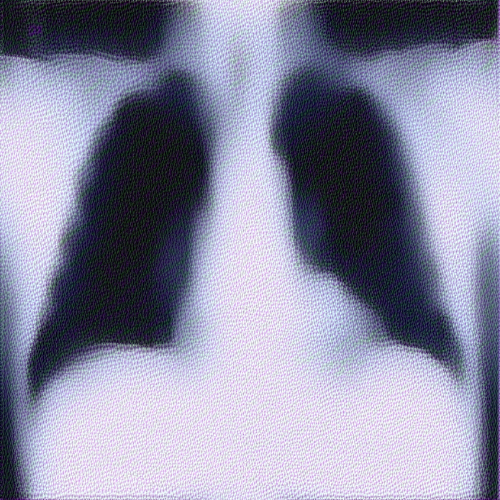

In [26]:
deep_patterns(base_model, names_1, original_img)

### Deep

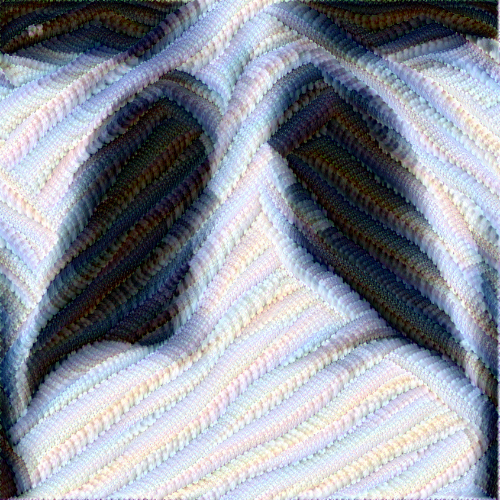

In [27]:
deep_patterns(base_model, names_2, original_img)

### Deeper!

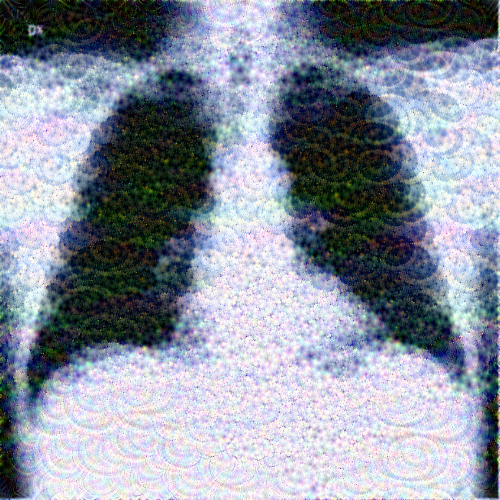

In [28]:
deep_patterns(base_model, names_3, original_img)

### Still deeper!

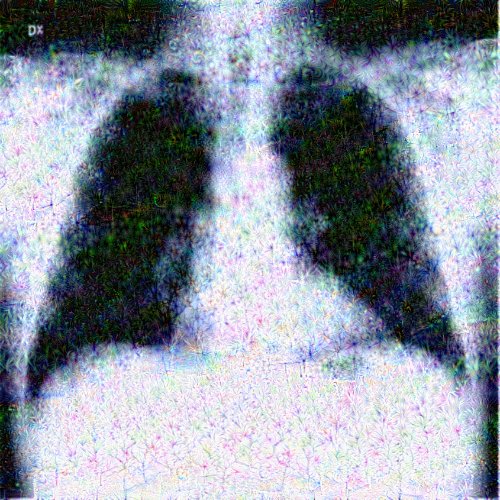

In [29]:
deep_patterns(base_model, names_4, original_img)

### We can see that the complexity of the patterns produced/visualised by the network increases as we go deeper and deeper. Analysis of these patterns might give insights into the decision making of, a rather, black-box network. Such analysis can also call for changes (architecture/parameters... etc.) in the network that can potentially enhance the network's performance! 